In [ ]:
"""
nodes: speakers
edges: when they use one same word 
        --> prune: keep only E(n1,n2)>= threshold(=alpha)
        

Created network with networkx;
Basic graph and nodes colored by
1. speaker profession
2. speaker age
3. K-means clustering
4. speech topic (assigned by NMF model)


"""

In [1]:
import re, itertools
import networkx as nx

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/katiehuang/Documents/metis/projects/onl_ds5_project_4/py')
from word_cloud import *
from clean import *
import importlib

## Load data and define df

In [8]:
speech_df_lemma = pd.read_pickle('../dump/speech_clean_lemma')
topic_df = pd.read_pickle('../dump/topic_df')
topic_word = pd.read_pickle('../dump/to_nx_topic_words')
# speaker_label = pd.read_pickle('../dump/speaker_label_nmf')
speech_df = pd.read_pickle('../dump/speech_df_speaker')

speech_concise = pd.read_pickle('../dump/speech_concise')

In [17]:
# (raw transcript)
# speech_df

### Save all category columns in one dataframe

In [32]:
speech_df['age_cat'] = speech_df['age_then'].apply(lambda x: str(x//10)+'0-'+str(x//10 + 1)+'0')

In [37]:
speech_df = speech_df.sort_values(by=['speaker','year']).reset_index(drop=True)

In [512]:
speech_df.head()

,speaker,profession,born,age,origin,category,year,school,transcript,length,age_then
0,SIDDHARTHA MUKHERJEE,American-Indian physician,1970,50,New Delhi India,Med/Law,2018,Univ. of Southern California,I wish someone had told me at my own commenc...,14487,48
1,JESMYN WARD,American novelist,1977,43,De Lisle MS,Publish,2018,Tulane University,Persist. Be patient. Be well. Good morning....,14063,41
2,DAVID SEDARIS,American humorist,1956,64,Johnson City NY,Entertainment,2018,OBERLIN COLLEGE,"Thank you so much for having me, and for prese...",10587,62
3,NIGHT SHYAMALAN,American-Indian filmmaker,1970,50,Mahé India,Entertainment,2018,DREXEL UNIVERSITY,\nwhat's up dragons alright let's start\n\nwit...,26406,48
4,TERRY TEACHOUT,American author,1955,65,Cape Girardeau MO,Publish,2018,HAMILTON HOLT SCHOOL,"I’m supposed to keep it short, and I approve o...",6288,63


In [39]:
# Picke
speech_df.to_pickle('../dump/speech_speaker_cat')

## Use speech_concise df

In [18]:
# speech_concise

In [20]:
# Select complete trancripts
speech_concise['length'] = speech_concise['transcript'].apply(lambda x: len(x.split(" ")))
speech_complete = speech_concise[speech_concise.length > 1000]

In [21]:
import pickle
with open("../dump/common_words.txt", "rb") as f:   # Unpickling
    common_words = pickle.load(f)

In [22]:
def corpus_remove_stop_words(transcript):
    
    add_stop_words = ['like','youre','ive','im','really','id','ve','just','dont','thi','wa',
                  'say','know','make','people']

    boring_words = ['say','like','just','dont','don','im',
                      'ive','youll','youve','things','thing','youre','right','really','lot',
                      'make','know','people','way','day','class']


    add_stop_words = add_stop_words + common_words + boring_words

    stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

    words = transcript.split(" ")
    new_words = [x for x in words if x not in stop_words]
    new_transcript = " ".join(new_words)
    return new_transcript

In [23]:
speech_complete['transcript_clean'] = speech_complete['transcript'].apply(corpus_remove_stop_words)

<ipython-input-23-cc34a06f8d22>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speech_complete['transcript_clean'] = speech_complete['transcript'].apply(corpus_remove_stop_words)


In [60]:
df_unique = speech_complete.copy()
df_unique.drop_duplicates(subset=['speaker'],inplace=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,speaker,year,school,transcript,transcript_clean,category,age,age_then,age_cat,region,length
0,CARLY FIORINA,2000,MIT,I'd like to start my remarks this morning with...,I'd start remarks morning special thanks sent ...,Tech/Business,66,46,40-50,east,3237
1,J.K. ROWLING,2008,Harvard University,"EXCERPTS Actually, I have wracked my mind and ...","EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,2329
2,JEAN ANDREWS,2003,University of Texas at Austin,\nWhen Dean Rankin invited me to present the c...,\nWhen Dean Rankin invited present commencemen...,Education/Research,97,80,80-90,central,1489
3,AARON SORKIN,2012,SYRACUSE UNIVERSITY,"Thank you very much. Madam Chancellor, member...","Thank much. Madam Chancellor, members Board T...",Publish,59,51,50-60,east,2579
4,ABBY WAMBACK,2018,Barnard College,"Failure is not something to be ashamed of, ...","Failure ashamed of, it's POWERED by. Failur...",Sport,40,38,30-40,east,2864
...,...,...,...,...,...,...,...,...,...,...,...
262,WILLIAM FOEGE,2016,Emory University,And that is why we have commencement talks. ...,And commencement talks. The university can't...,Publish,84,80,80-90,east,2753
263,WYNTON MARSALIS,2001,CONNECTICUT COLLEGE,"You know, I never write a speech because I fee...","You know, I write speech I feel write somethin...",Art,59,40,40-50,east,2610
264,YVONNE THORNTON,2003,TUSKEGEE UNIVERSITY,"Thank you, President Payton. I would also like...","Thank you, President Payton. I thank Board Tru...",Med/Law,73,56,50-60,east,2236
265,YVONNE THORTON,2003,TUSKEGEE UNIVERSITY,"Thank you, President Payton. I would also like...","Thank you, President Payton. I thank Board Tru...",Med/Law,73,56,50-60,east,2236


In [69]:
# Select famous speaker for visualization
selected_speaker = [
    'BROOKE SHIELDS','DENZEL WASHINGTON','ELLEN DEGENERES','JIM CARREY','JODIE FOSTER','LISA KUDROW','MERYL STREEP',
 'MINDY KALING','OCTAVIA SPENCER','OPRAH WINFREY','STEVEN SPIELBERG','TOM HANKS','WILL FERRELL',
 'BILL GATES','JERRY YANG','MARK ZUCKERBERG','SHERYL SANDBERG','THEO EPSTEIN','TIM COOK','LARRY PAGE',
 'GUIDO CALABRESI','SANJAY GUPTA','ELIAS A ZERHOUNI','NEIL DEGRASSE',
 ' J.K. ROWLING','ANDERSON COOPER','DANIEL PINK','JOHN GREEN','RITA DOVE','STEPHEN KING',
 'ARNOLD SCHWARZENEGGER','BARACK OBAMA','BILL CLINTON','ELIZABETH WARREN','GEORGE W BUSH',
    'MICHAEL BLOOMBERG','MICHELLE OBAMA',]

In [412]:
len(selected_speaker)

37

In [383]:
num_rows = 40
df = df_unique[df_unique.speaker.isin(selected_speaker)]\
    [['speaker','year','transcript_clean','category','age','age_then','age_cat','region']].reset_index(drop=True)
df.index = df.speaker.tolist()
# df
df['length'] = df['transcript_clean'].apply(lambda x: len(x.split(" ")))

In [384]:
df

,speaker,year,transcript_clean,category,age,age_then,age_cat,region,length
J.K. ROWLING,J.K. ROWLING,2008,"EXCERPTS Actually, I wracked mind heart I ough...",Publish,55,43,40-50,east,1103
ANDERSON COOPER,ANDERSON COOPER,2010,"Thank you, does feel harry potter convention? ...",Publish,53,43,40-50,central,1099
ARNOLD SCHWARZENEGGER,ARNOLD SCHWARZENEGGER,2009,"Well, thank much. Hello, everybody. What intro...",Politics,73,62,60-70,west,1891
BARACK OBAMA,BARACK OBAMA,2009,"Thank you. Thank you. Thank you, ASU. Thank mu...",Politics,59,48,40-50,west,1566
BILL CLINTON,BILL CLINTON,2010,"Thank much, ladies gentlemen.I went said word ...",Politics,74,64,60-70,east,1951
BILL GATES,BILL GATES,2007,"President Bok, President Rudenstine, incoming ...",Tech/Business,65,52,50-60,east,1346
BROOKE SHIELDS,BROOKE SHIELDS,2015,Some lessons don’t change. They highlighted...,Entertainment,55,50,50-60,east,1354
DANIEL PINK,DANIEL PINK,2014,Thank You president Shapiro\n\nDean Mangelsdor...,Publish,56,50,50-60,east,740
DENZEL WASHINGTON,DENZEL WASHINGTON,2011,thank thank much\n\nI obviously unorganized\n\...,Entertainment,66,57,50-60,east,1349
ELIAS A ZERHOUNI,ELIAS A ZERHOUNI,2004,Thank much. It's privilege celebrate beautiful...,Science,69,53,50-60,east,1261


In [134]:
speaker_word = cv_dtm(df,'transcript_clean',add_stop_words=[])
speaker_word['zsum'] = speaker_word.sum(axis=1)

862

In [137]:
# Note that this cell will take longer to run as the relationship are added

# speaker_word = cv_dtm(df,'transcript_clean',add_stop_words=[])

# Prepare nodes
node_list = list(df.index)

# Prepare edges
from collections import defaultdict
speaker_word_assoc_original = defaultdict(lambda: 0)

relationships = itertools.combinations(node_list,2) 
for relationship in relationships:
#     print(relationship)
    for word in speaker_word.columns[:-1]:
        if (speaker_word.loc[relationship[0],word] != 0) & \
           (speaker_word.loc[relationship[1],word] != 0):
                speaker_word_assoc_original[relationship] += 1
#     print(speaker_word_assoc_original[relationship])
    
    # Normalize
    total_words = speaker_word.loc[relationship[0]]['zsum'] + speaker_word.loc[relationship[1]]['zsum']
#     print(total_words)
    speaker_word_assoc_original[relationship] = speaker_word_assoc_original[relationship] / total_words
#     print(speaker_word_assoc_original[relationship])

## Network graph

In [88]:
# Note that this cell will take longer to run as the relationship are added

speaker_word = cv_dtm(df,'transcript_clean',add_stop_words=[])

# Prepare nodes
node_list = list(df.index)

# Prepare edges
from collections import defaultdict
speaker_word_assoc_original = defaultdict(lambda: 0)

relationships = itertools.combinations(node_list,2) 
for relationship in relationships:
    for word in speaker_word.columns:
        if (speaker_word.loc[relationship[0],word] != 0) & \
           (speaker_word.loc[relationship[1],word] != 0):
                speaker_word_assoc_original[relationship] += 1

In [208]:
# Specify the threshold for pruning
alpha = 0.8

speaker_word_assoc = speaker_word_assoc_original.copy()

min_edge = min(speaker_word_assoc.values())
max_edge = max(speaker_word_assoc.values())
for key, value in speaker_word_assoc.items():
    if value/max_edge > alpha:
        speaker_word_assoc[key] = value/max_edge
    else:
        speaker_word_assoc[key] = 0

In [209]:
# speaker_word_assoc

### 1. Basic graph

In [506]:
# pos

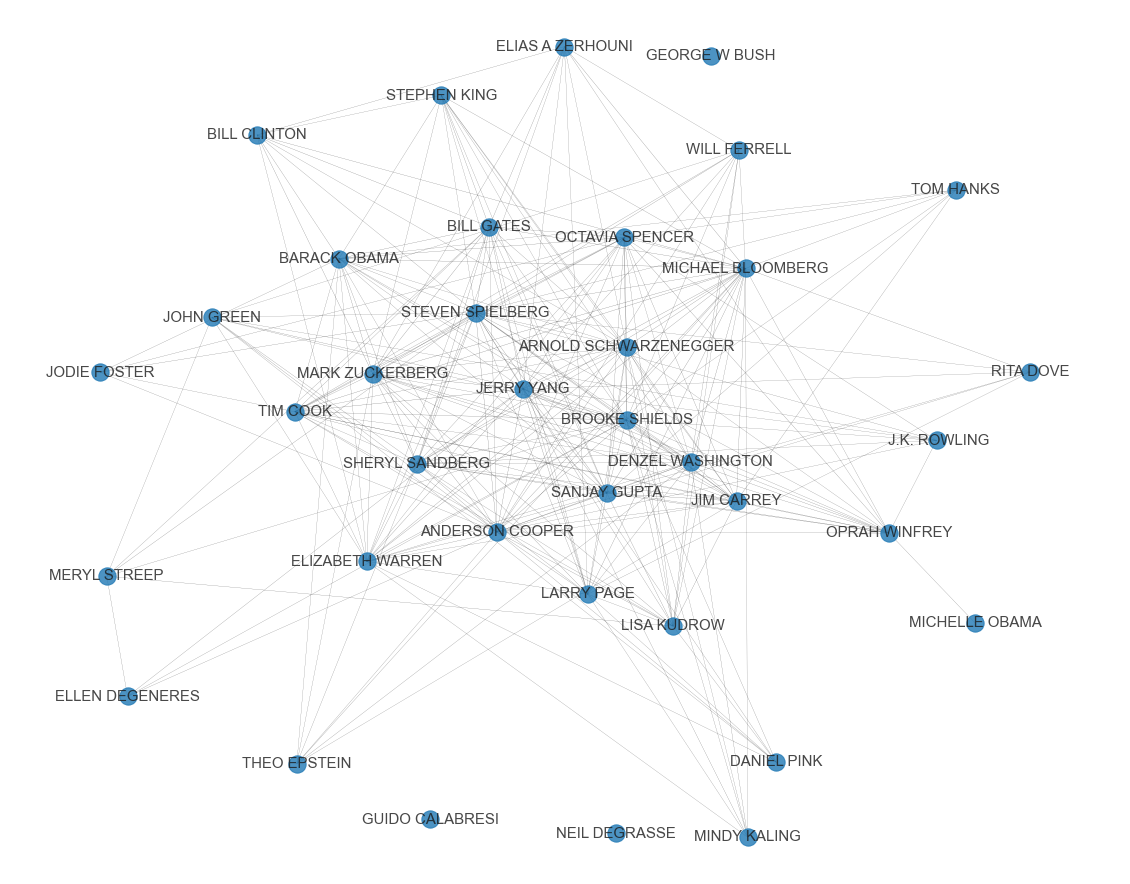

In [315]:
G = nx.Graph()

# Create nodes and edges
for node in node_list:
    G.add_node(node)
for edge, weight in speaker_word_assoc.items():
    if weight != 0:
        G.add_edge(edge[0], edge[1], weight=(weight))
        
# Draw

plt.rcParams['figure.figsize'] = [20, 16]

fig,ax=plt.subplots()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.spring_layout(G, seed=37, iterations=60, scale=1, k=2)
pos['OPRAH WINFREY'] = np.array([0.68491992, -0.25])
pos['MICHAEL BLOOMBERG'] = np.array([0.39275478, 0.4027777 ])
pos['BROOKE SHIELDS'] = np.array([0.1504149 , 0.02871294])

# pos = nx.nx_pydot.graphviz_layout(G)                         # position of nodes
nx.draw(G, pos,
        with_labels=True, font_size=15,                         # node label
#             node_color=node_label, cmap='Pastel1',                          # node colorr
#             nodelist = node_list, node_size=[v*6000 for v in node_label],  # mode size
            width=[weight*.2 for weight in weights], alpha=0.8,ax=ax,                            # edge width and transparency
             )

x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.1
plt.xlim(x_min - x_margin, x_max + x_margin)

fig.savefig('../plot/nx_test.pdf', bbox_inches='tight', transparent = True);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


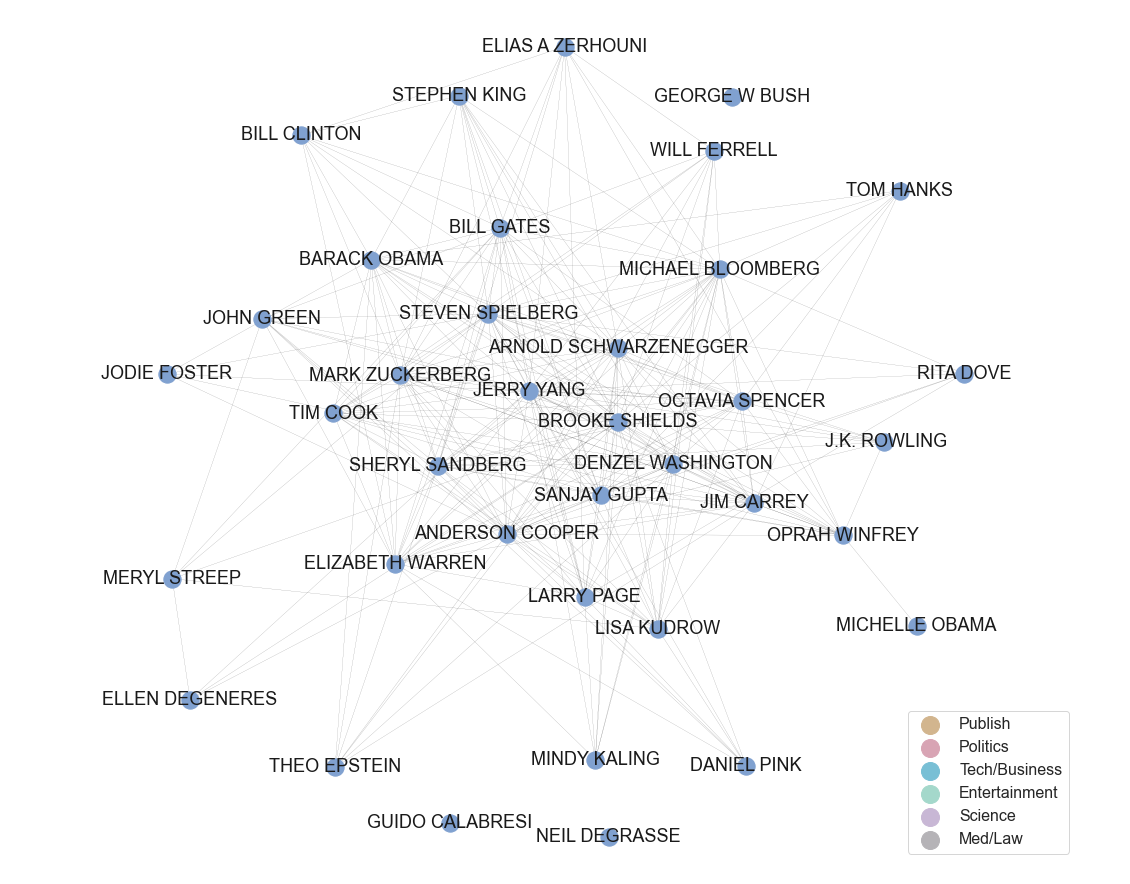

In [363]:
G = nx.Graph()

# Create nodes and edges
for node in node_list:
    G.add_node(node)
for edge, weight in speaker_word_assoc.items():
    if weight != 0:
        G.add_edge(edge[0], edge[1], weight=(weight))
        
# Draw

plt.rcParams['figure.figsize'] = [20, 16]

fig,ax=plt.subplots()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.spring_layout(G, seed=37, iterations=60, scale=1, k=2)
pos['OPRAH WINFREY'] = np.array([0.68491992, -0.25])
pos['MICHAEL BLOOMBERG'] = np.array([0.39275478, 0.4027777 ])
pos['BROOKE SHIELDS'] = np.array([0.1504149 , 0.02871294])
pos['OCTAVIA SPENCER'] = np.array([0.44570498, 0.07902821])
pos['JIM CARREY'] = np.array([ 0.47439382, -0.1711607 ])
pos['MINDY KALING'] = np.array([ 0.09718083, -0.8]) 
pos['GEORGE W BUSH'] = np.array([0.42263619, 0.82671188])

    
# pos = nx.nx_pydot.graphviz_layout(G)                         # position of nodes
nx.draw(G, pos, with_labels=True, font_size=18,                         # node label
        node_color = np.array((128, 162, 209))/256,
#         node_color=node_label, cmap=cmap,                          # node colorr
        nodelist = node_list, node_size=300,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

cmap = plt.get_cmap(cmap)
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 16},bbox_to_anchor=(0.8, 0.2));


x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.2
plt.xlim(x_min - x_margin, x_max + x_margin)

fig.savefig('../plot/nx_test.pdf', bbox_inches='tight', transparent = True);

pos_want = pos

### 2. Add attributes
Color the nodes (speakers) based on category of profession and age group.

### A. Category (of profession) 
node_label from 'category'

In [240]:
# df.head()

In [397]:
first20 = df.iloc[:num_rows]

# Add attribute ('profession') for node color
num_professions = 4
interval = num_rows // num_professions

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['category'] = first20.loc[n].category


# Assign values to 'type' (if want to use 'type' as node size partition)
types = df.category.unique().tolist()
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['category']] for n in nodes]

In [398]:
# pos_want_40 = pos

In [399]:
# # With legend
# plt.rcParams['figure.figsize'] = [20, 16]
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
# nx.draw(G, pos=pos_want, with_labels=True, font_size=20,                         # node label
#         node_color=node_label, cmap='Pastel1',                          # node colorr
#         nodelist = node_list, node_size=1000,
# #         [v*6000 for v in node_label],  # mode size
#         width=.1, alpha=1,                                            # edge width and transparency
#         )

# # pos_want = pos

# # Includ legend
# cmap = plt.get_cmap('Pastel1')
# maxval = np.max(node_label) 
# [cmap(v/maxval) for v in node_label]
# for v in set(node_label):
#     plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
# plt.legend(markerscale=3, prop={'size': 20});

In [400]:
# Create an array with the colors you want to use
colors = ["#D3B68F", "#663399", "#D4E0E6", "#DAD1E4" ,"#DAD1E1" ,"#F8E0D9"]

colors = [np.array((211, 182, 143)), np.array((217, 165, 181)), np.array((120, 192, 214)), 
          np.array((165, 217, 204)), np.array((201, 184, 214)), np.array((182, 180, 184))]
profession_colors = [color/256 for color in colors]

# 73, 179, 149
# publish #D3B68F
# politics #663399
# tech #D4E0E6
# enter #DAD1E1
# academia #DAD1E1
# med #F8E0D9


# Set your custom color palette

sns.set_palette(sns.color_palette(profession_colors))
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(profession_colors)

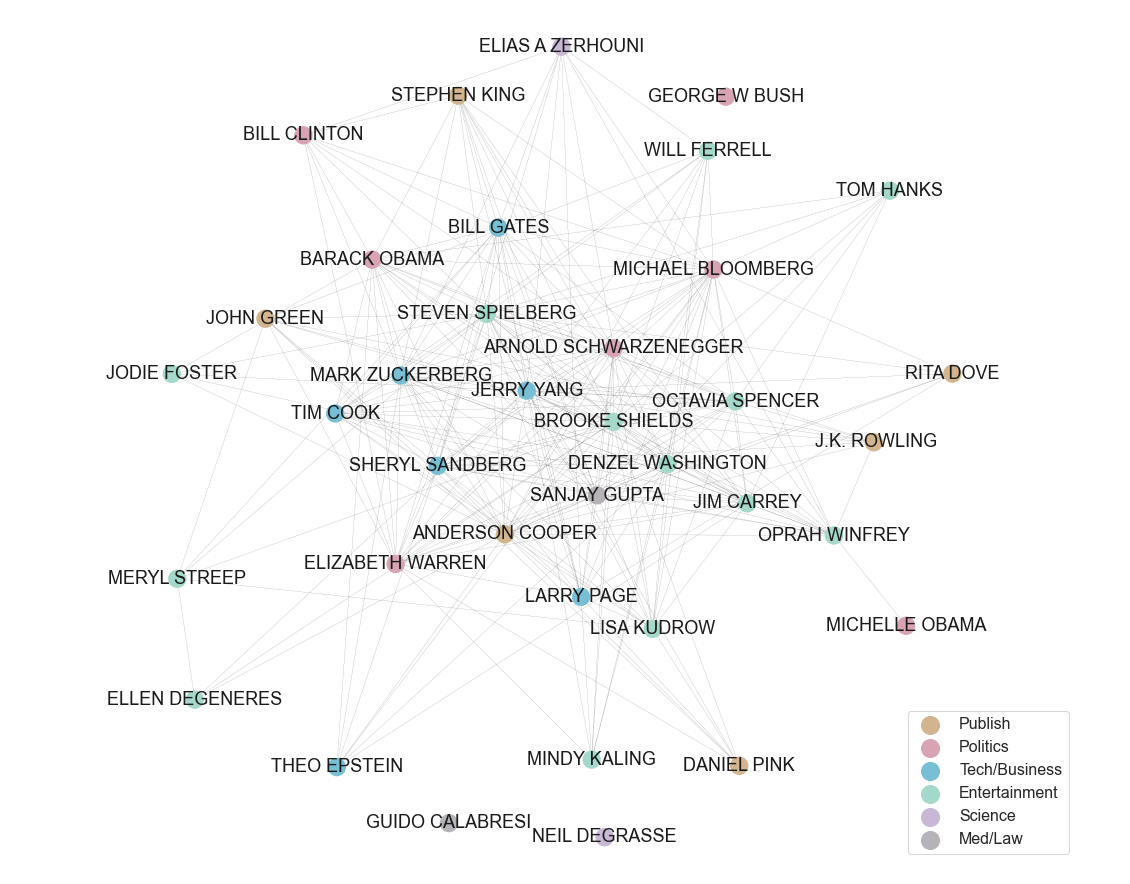

In [401]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
fig,ax=plt.subplots()
sns.set_style("white")
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8) # position of nodes

color_palette = 'Set2'
nx.draw(G, pos=pos_want, with_labels=True, font_size=18,                         # node label
        node_color=node_label, cmap=cmap,                          # node colorr
        nodelist = node_list, node_size=300,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# pos_want = pos

# Includ legend
cmap = plt.get_cmap(cmap)
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 16},bbox_to_anchor=(0.8, 0.2));


x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.2
plt.xlim(x_min - x_margin, x_max + x_margin)

fig.savefig('../plot/nx_profession.pdf', bbox_inches='tight', transparent = True);

### B. Age of speaker

In [456]:
df['age_cat'] = df['age_then'].apply(lambda x: str(x//10)+'0-'+str(x//10 + 1)+'0')

In [457]:
first20 = df.iloc[:num_rows]

# Add attribute ('profession') for node color

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['age_cat'] = first20.loc[n].age_cat


# Assign values to 'type' (if want to use 'type' as node size partition)
types = sorted(df.age_cat.unique().tolist())
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['age_cat']] for n in nodes]

In [458]:
# # With legend
# plt.rcParams['figure.figsize'] = [20, 16]
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
# nx.draw(G, pos=pos_want, with_labels=True, font_size=20,                         # node label
#         node_color=node_label, cmap='Pastel1',                          # node colorr
#         nodelist = node_list, node_size=1000,
# #         [v*6000 for v in node_label],  # mode size
#         width=.1, alpha=1,                                            # edge width and transparency
#         )

# # Includ legend
# cmap = plt.get_cmap('Pastel1')
# maxval = np.max(node_label) 
# [cmap(v/maxval) for v in node_label]
# for v in set(node_label):
#     plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
# plt.legend(markerscale=3, prop={'size': 20});

In [459]:
# df

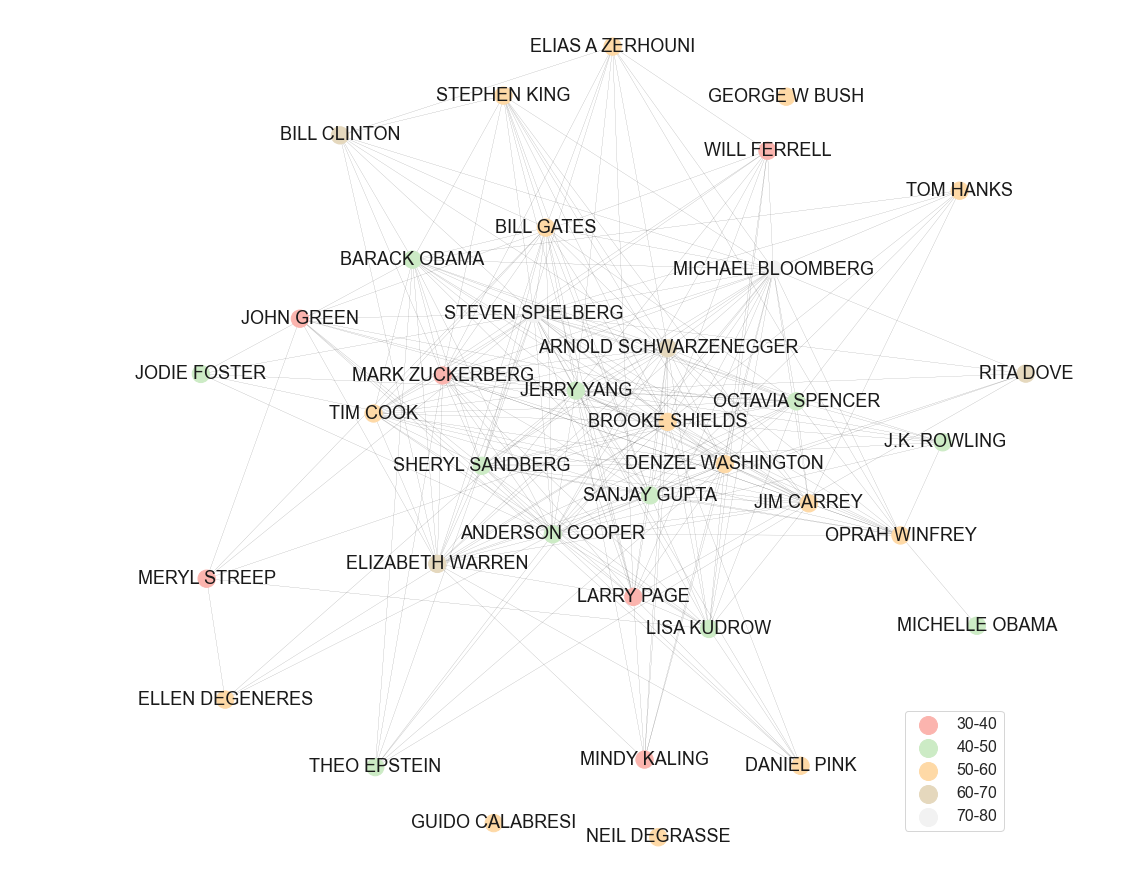

In [460]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
fig,ax=plt.subplots()
sns.set_style("white")
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8) # position of nodes

cmap = 'Pastel1'
nx.draw(G, pos=pos_want, with_labels=True, font_size=18,                         # node label
        node_color=node_label, cmap=cmap,                          # node colorr
        nodelist = node_list, node_size=300,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# pos_want = pos

# Includ legend
cmap = plt.get_cmap(cmap)
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 16},bbox_to_anchor=(0.9, 0.2));


x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.2
plt.xlim(x_min - x_margin, x_max + x_margin)

fig.savefig('../plot/nx_age.pdf', bbox_inches='tight', transparent = True);

### C. Label from K-means clustering

In [16]:
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline

In [501]:
speech_df_x = wash(df,'transcript_clean').copy()

In [502]:
tfidf = TfidfVectorizer()
csr_mat = tfidf.fit_transform(speech_df_x['transcript_clean'])
svd = TruncatedSVD(n_components=50)
kmeans = KMeans(n_clusters=5)
pipeline = make_pipeline(svd,kmeans)
pipeline.fit(csr_mat)

Pipeline(steps=[('truncatedsvd', TruncatedSVD(n_components=50)),
                ('kmeans', KMeans(n_clusters=5))])

In [503]:
# Predict (assign each speaker a label)
labels = pipeline.predict(csr_mat)
df['cluster'] = labels

In [504]:
df.head()

,speaker,year,transcript_clean,category,age,age_then,age_cat,region,length,nouns,cluster
J.K. ROWLING,J.K. ROWLING,2008,i wrack mind heart i ought today i ask i wish ...,Publish,55,43,40-50,east,1103,heart i today i graduation lessons i gather ce...,1
ANDERSON COOPER,ANDERSON COOPER,2010,you do feel harry potter convention renaissanc...,Publish,53,43,40-50,central,1099,convention renaissance members parent model co...,0
ARNOLD SCHWARZENEGGER,ARNOLD SCHWARZENEGGER,2009,thank much everybody what introduction wonderf...,Politics,73,62,60-70,west,1891,everybody introduction thing get havent hear a...,1
BARACK OBAMA,BARACK OBAMA,2009,you you you much please thank you extremely ge...,Politics,59,48,40-50,west,1566,introduction inspire leadership thank communit...,0
BILL CLINTON,BILL CLINTON,2010,much ladies gentlemeni go say word see article...,Politics,74,64,60-70,east,1951,ladies word see article ask speech i anybody f...,1


In [505]:
first20 = df.iloc[:num_rows]

# Add attribute ('cluster') for node color

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['cluster'] = first20.loc[n].cluster


# Assign values to 'type' (if want to use 'type' as node size partition)
types = sorted(df.cluster.unique().tolist())
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['cluster']] for n in nodes]

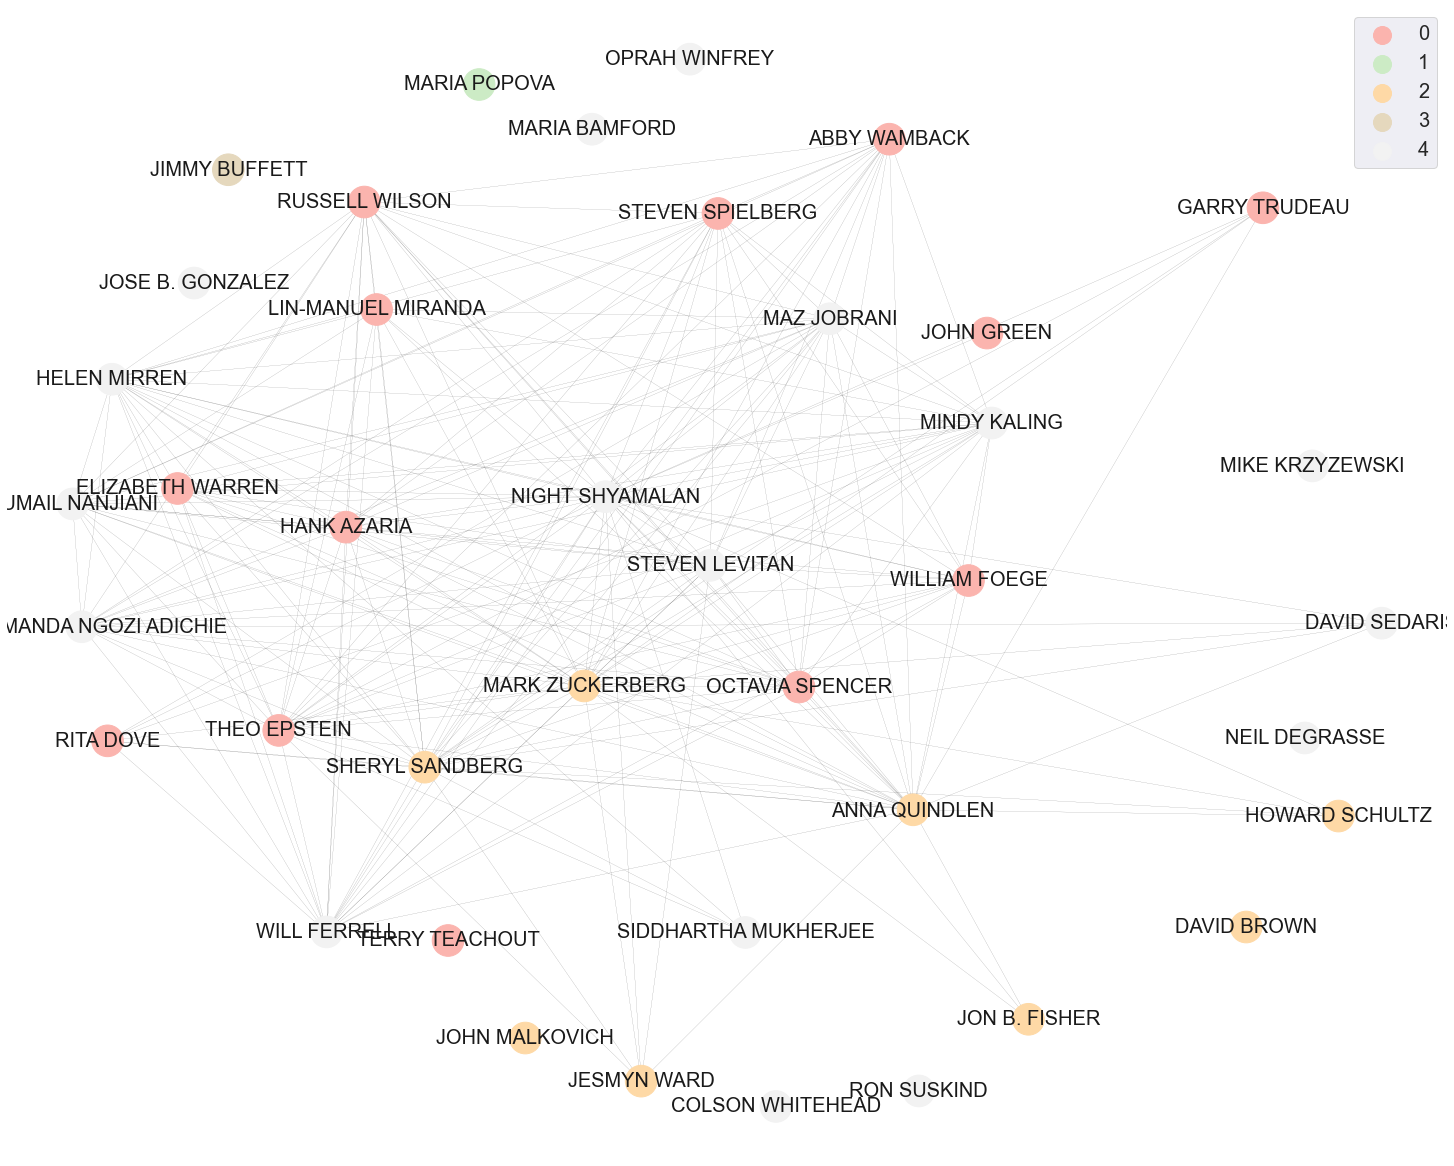

In [92]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
nx.draw(G, pos=pos_want, with_labels=True, font_size=20,                         # node label
        node_color=node_label, cmap='Pastel1',                          # node colorr
        nodelist = node_list, node_size=1000,
#         [v*6000 for v in node_label],  # mode size
        width=.1, alpha=1,                                            # edge width and transparency
        )

# Includ legend
cmap = plt.get_cmap('Pastel1')
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 20});

### D. Topic modeling (NMF)

In [450]:
# column_name = 'transcript_clean'
# num_topic = 5

# # Prepare Tf-idf
# tfidf = TfidfVectorizer()
# csr_mat = tfidf.fit_transform(speech_df_x[column_name])
# doc_word = tfidf_dtm(speech_df_x,column_name)

# # Modeling
# nmf_model = NMF(num_topic, max_iter=1000)
# doc_topic = nmf_model.fit_transform(doc_word)
# doc_assigned_topic = doc_topic.argsort(axis=1)[:,-1]

# # Use components in NMF model to find the top 10 words for a given topic
# topics = nmf_model.components_.argsort(axis=1)[:,-1:-11:-1]

# # Create topic_worrd df
# words = doc_word.columns
# topic_words = [[words[index] for index in topic] for topic in topics]
# topic_word_df = pd.DataFrame(topic_words,index=['Topic #' + '{:02d}'.format(i+1) for i in range(num_topic)])

In [452]:
# topic_word_df

In [451]:
# # Create column for topic
# df['topic'] = doc_assigned_topic
# df['topic'] = df['topic'].apply(lambda x: 'Topic #'+str(x+1))

In [507]:
# Import df with assigned topic from NMF (notebook: topic_modeling_refine)
speech_topic_NMF = pd.read_pickle('../dump/speech_topic_NMF')
first20 = df.iloc[:num_rows]
test_join = pd.merge(first20,speech_topic_NMF[['speaker','year','TOPIC']],on=['speaker','year'])
test_join.index = test_join.speaker.tolist()

In [508]:
# test_join

In [509]:
first20 = test_join.iloc[:num_rows]

# Add attribute ('topic') for node color

for n, d in list(G.nodes(data=True)):
    G.nodes[n]['TOPIC'] = first20.loc[n].TOPIC


# Assign values to 'type' (if want to use 'type' as node size partition)
types = sorted(first20['TOPIC'].unique().tolist())
mapping = {category_name: i for i, category_name in enumerate(types)}
nodes = G.nodes()
node_label = [mapping[G.nodes[n]['TOPIC']] for n in nodes]

In [510]:
# Create an array with the colors you want to use
colors = [np.array((135, 122, 150)), np.array((137, 67, 186)), np.array((158, 181, 219)), np.array((77, 219, 200)),
          np.array((227, 185, 86)), np.array((214, 188, 159)), np.array((189, 130, 143)), np.array((161, 112, 148))]
topic_colors = [color/256 for color in colors]

# 135, 122, 150
# 137, 67, 186
# 158, 181, 219
# 155, 194, 190
# 227, 223, 213
# 214, 188, 159
# 189, 130, 143
# 161, 112, 148

# Set your custom color palette
sns.set_palette(sns.color_palette(topic_colors))
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
cmap = ListedColormap(topic_colors)

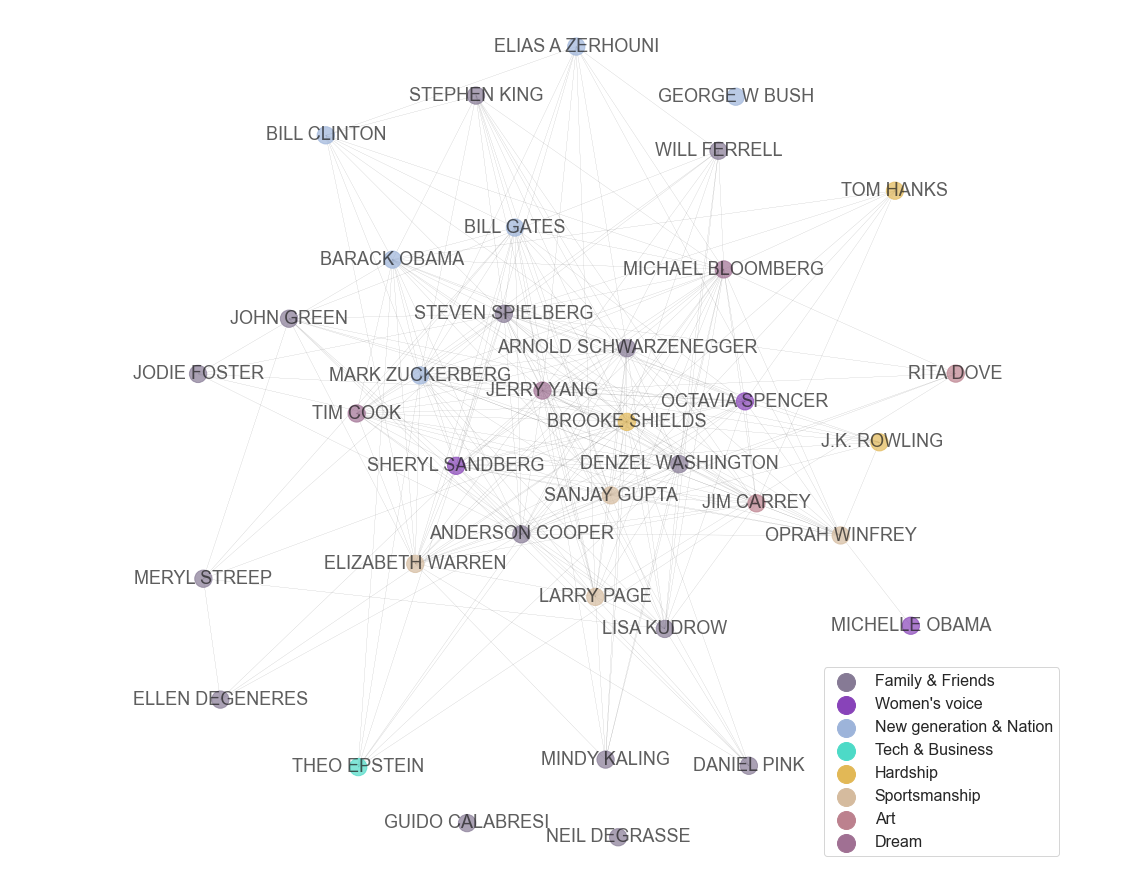

In [511]:
# With legend
plt.rcParams['figure.figsize'] = [20, 16]
fig,ax=plt.subplots()
sns.set_style("white")
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8) # position of nodes

# cmap = plt.get_cmap('twilight_shifted')
nx.draw(G, pos=pos_want, with_labels=True, font_size=18,                         # node label
        node_color=node_label, cmap=cmap, alpha = 0.7,                         # node colorr
        nodelist = node_list, node_size=300,
#         [v*6000 for v in node_label],  # mode size
        width=.1,                                            # edge width and transparency
        )

# pos_want = pos

# Includ legend
cmap = plt.get_cmap(cmap)
maxval = np.max(node_label) 
[cmap(v/maxval) for v in node_label]
types = ['Family & Friends', "Women's voice", "New generation & Nation",
                                                  'Tech & Business', 'Hardship', 'Sportsmanship', 'Art', 'Dream']

for v in set(node_label):
    plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
plt.legend(markerscale=3, prop={'size': 16},bbox_to_anchor=(0.95, 0.25));


x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.2
plt.xlim(x_min - x_margin, x_max + x_margin)

fig.savefig('../plot/nx_nmf.pdf', bbox_inches='tight', transparent = True);

In [493]:
# # With legend
# plt.rcParams['figure.figsize'] = [20, 16]
# pos = nx.spring_layout(G, iterations=20, scale=1, k=0.8)             # position of nodes
# nx.draw(G, pos=pos_want, with_labels=True, font_size=20,                         # node label
#         node_color=node_label, cmap='Pastel1',                          # node colorr
#         nodelist = node_list, node_size=1000,
# #         [v*6000 for v in node_label],  # mode size
#         width=.1, alpha=1,                                            # edge width and transparency
#         )

# # Includ legend
# cmap = plt.get_cmap('Pastel1')
# maxval = np.max(node_label) 
# [cmap(v/maxval) for v in node_label]
# types = ['Family & Friends', "Women's voice", "New generation & Nation",
#                                                   'Tech & Business', 'Hardship', 'Sportsmanship', 'Art', 'Dream']
# for v in set(node_label):
#     plt.scatter([],[], c=[cmap(v/maxval)], label=types[v])
# plt.legend(markerscale=3, prop={'size': 20});

## Save .csv file for textnets package run in R



**code**

```
# Load csv file
speech = read.csv("~/Documents/metis/resource/textnets/data/test_df.csv", header=TRUE)

# Group by speakers and select first speech of each speaker
speech_firsts <- speech %>% group_by(speaker) %>% slice(1L)

# Preprocessing and select nouns
speech_firsts_nouns <- PrepText(speech_firsts, groupvar = "speaker", textvar = "transcript", node_type = "groups", tokenizer = "words", pos = "nouns", remove_stop_words = TRUE, compound_nouns = TRUE)

# Create textnet
speech_firsts_network <- CreateTextnet(speech_firsts_nouns)

# 2D graph (can adjust alpha to create cliques)
VisTextNet(speech_firsts_network, label_degree_cut = 0)
VisTextNet(speech_firsts_network, label_degree_cut = 1, alpha=.15)

# 3D
VisTextNetD3(speech_firsts_network,alpha=.1,zoom=TRUE)

# Save graph as pdf
pdf(file = "/Users/katiehuang/Desktop/textnet.pdf",
    width = 4,
    height = 6) 
VisTextNet(speech_firsts_network, label_degree_cut = 0, alpha=.055)
dev.off()
```

In [514]:
# df of selected speakers
selected_df = speech_df[speech_df.speaker.isin(selected_speaker)]
selected_df['transcript'] = selected_df.transcript.apply(corpus_remove_stop_words)

<ipython-input-514-caac9fa3fb2c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['transcript'] = selected_df.transcript.apply(corpus_remove_stop_words)


In [517]:
# Other random speakers from speech_df
random_df = speech_df.iloc[:30]
R_network = pd.concat([selected_df, random_df],axis=0)
# R_network

In [522]:
R_network.speaker.nunique()

51

In [ ]:
# This is the file to load in textnet R!!

R_network.to_csv('../dump2/R_network.csv')